In [3]:
# !pip install tensorflow
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import opendatasets as od
from PIL import Image

from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

2024-01-13 21:19:10.936737: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 21:19:10.971984: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-13 21:19:10.972018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-13 21:19:10.972761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-13 21:19:10.978347: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-13 21:19:10.978914: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Test what we can do with images

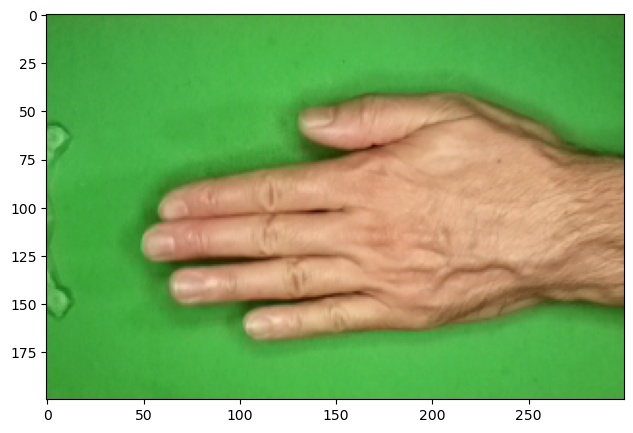

In [2]:
image = np.array(Image.open('data/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png'))
plt.imshow(image)
plt.show()

In [3]:
flipped1 = tf.image.flip_left_right(image)
flipped2 = tf.image.flip_up_down(image)
flipped3 = tf.image.flip_up_down(flipped1)
flipped = [image, flipped1, flipped2, flipped3]

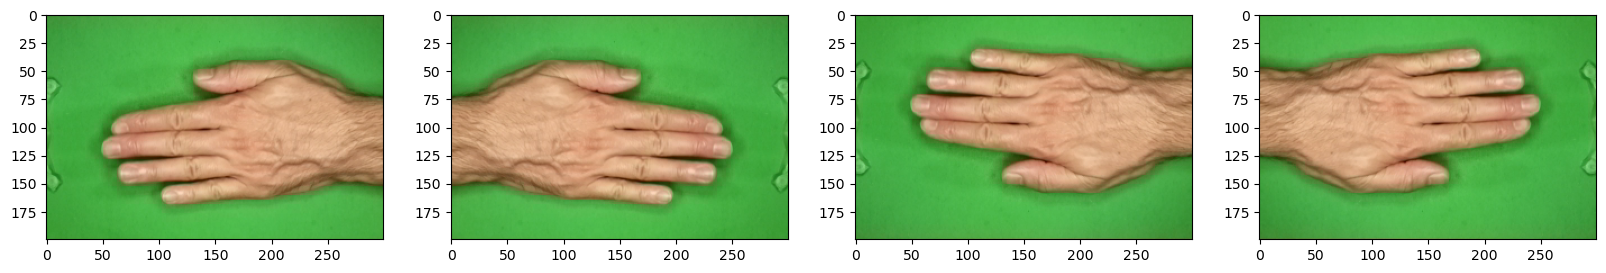

In [4]:
fig, ax = plt.subplots(1, len(flipped))
for i,img in enumerate(flipped):
    ax[i].imshow(img)
plt.show()

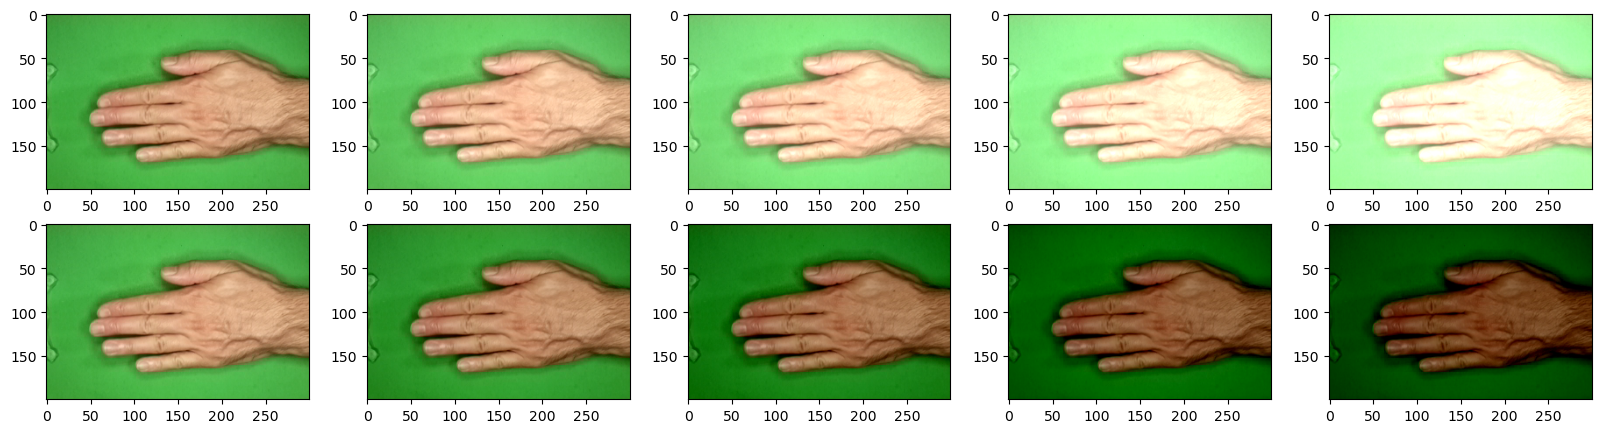

In [5]:
N,M = 2,5
fig, ax = plt.subplots(N, M)
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(tf.image.adjust_brightness(image, (j/10)*(-1)**i))
plt.show()

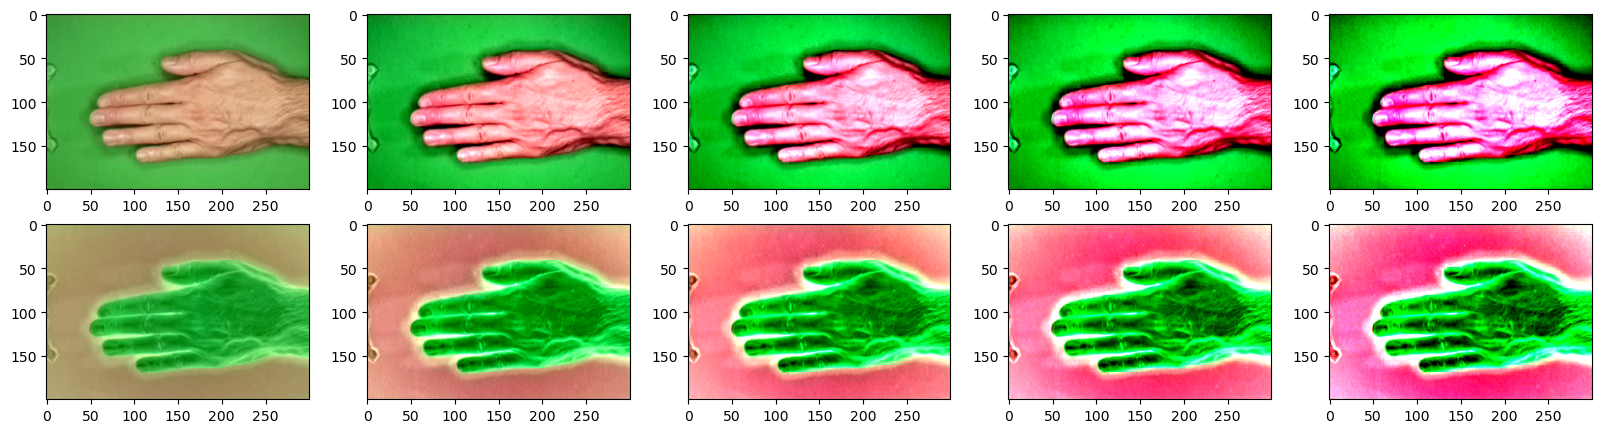

In [6]:
N,M = 2,5
fig, ax = plt.subplots(N, M)
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(tf.image.adjust_contrast(image, (j+1)*(-1)**i))
plt.show()

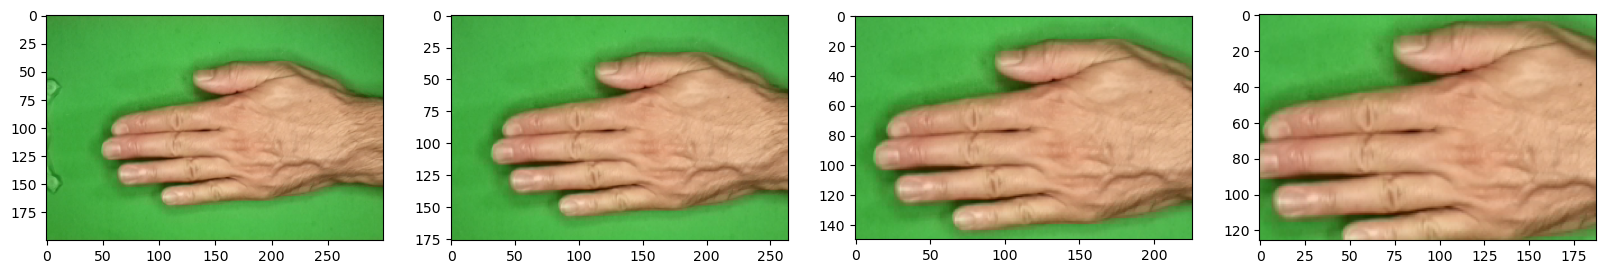

In [7]:
N = 4
fig, ax = plt.subplots(1, N)
for i in range(N):
    ax[i].imshow(tf.image.central_crop(image, 1-i/8))
plt.show()

In [8]:
grayscale = np.array(tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(image)))

no_red = image.copy()
no_red[:,:,0] = 0

no_green = image.copy()
no_green[:,:,1] = 0

no_blue = image.copy()
no_blue[:,:,2] = 0

max_red = image.copy()
max_red[:,:,0] = 255

max_green = image.copy()
max_green[:,:,1] = 255

max_blue = image.copy()
max_blue[:,:,2] = 255

other_colors = np.array([[image, no_red, no_green, no_blue],
                         [grayscale, max_red, max_green, max_blue]])

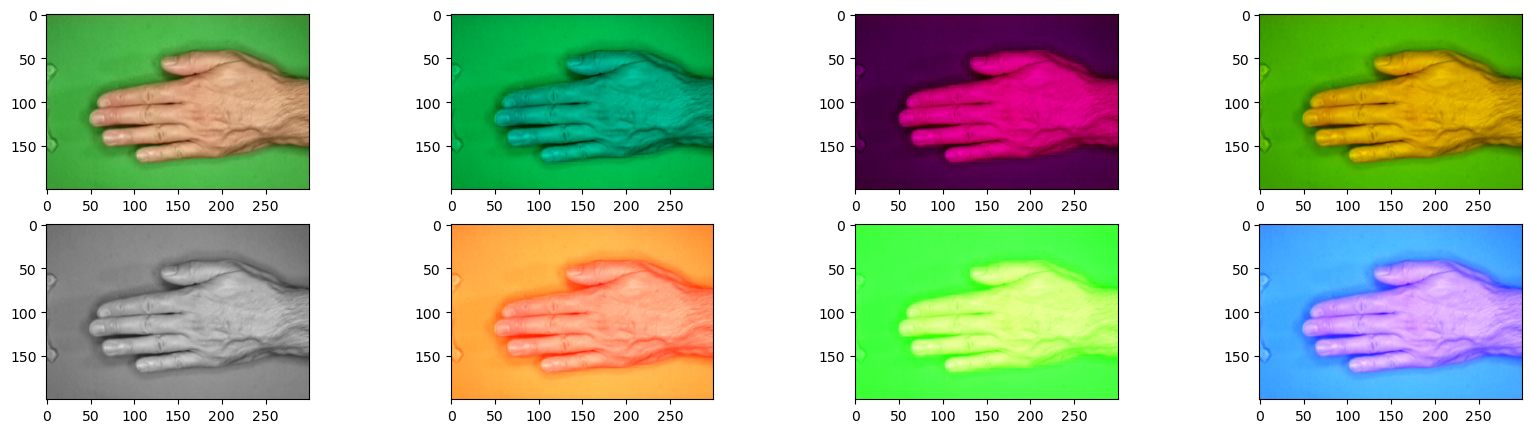

In [9]:
N, M = other_colors.shape[0], other_colors.shape[1]
fig, ax = plt.subplots(N, M)
for i in range(N):
    for j in range(M):
        ax[i,j].imshow(other_colors[i,j])
plt.show()

# Rotations

In [10]:
# !pip install opencv-python
import cv2

def clear_folder(folder_path):
    if os.path.exists(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)
            except Exception as e:
                print(f"Nie udało się usunąć pliku/folderu {file_path}: {e}")
    else:
        print(f"Ścieżka {folder_path} nie istnieje.")
        
        
        
def rotate_images(input_folder, output_folder, angle_range=(-180, 180), step=10):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):

            image_path = os.path.join(input_folder, filename)
            img = cv2.imread(image_path)

            for angle in range(angle_range[0], angle_range[1] + 1, step):
                rotated_img = rotate_image(img, angle)
                output_filename = f"{filename.split('.')[0]}_{angle}deg.{filename.split('.')[-1]}"
                output_path = os.path.join(output_folder, output_filename)
                cv2.imwrite(output_path, rotated_img)

def rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return rotated_image

# input_folder = "data/rockpaperscissors/rock"
# output_folder = "data/rockpaperscissors/rock-rotated"
# clear_folder(output_folder)
# rotate_images(input_folder, output_folder)

# input_folder = "data/rockpaperscissors/paper"
# output_folder = "data/rockpaperscissors/paper-rotated"
# clear_folder(output_folder)
# rotate_images(input_folder, output_folder)

# input_folder = "data/rockpaperscissors/scissors"
# output_folder = "data/rockpaperscissors/scissors-rotated"
# clear_folder(output_folder)
# rotate_images(input_folder, output_folder)

# KNN on augmented dataset

In [11]:
TRAIN_N, TEST_N = 500, 200
N = TRAIN_N + TEST_N

# classes = ['rock', 'paper', 'scissors']
classes = ['rock-rotated', 'paper-rotated', 'scissors-rotated']

TRAIN_N, TEST_N = len(classes)*TRAIN_N, len(classes)*TEST_N

X = []
y = []

color_transform = np.array([65536, 256, 1])

for class_id, class_name in enumerate(classes):
    for filename in os.listdir(f'./data/rockpaperscissors/{class_name}')[:N]:
        image = np.array(Image.open(f'./data/rockpaperscissors/{class_name}/{filename}'))
        X.append(image.dot(color_transform).flatten())
        y.append(class_id)

perm = np.random.permutation(len(y))

X = np.array(X)[perm]
y = np.array(y)[perm]

train_X, train_y = X[:TRAIN_N], y[:TRAIN_N]
test_X, test_y = X[TRAIN_N:], y[TRAIN_N:]

In [12]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X, train_y)
model.score(test_X, test_y)

0.8083333333333333

# PCA on augmented dataset

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(train_X)

X_trn_pca = pca.transform(train_X)
# X_trn_pca.shape
X_tst_pca = pca.transform(test_X)
# X_tst_pca.shape

clf_pca = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
clf_pca.fit(X_trn_pca, train_y)

# (clf_pca.predict(X_trn_pca) == train_Y).mean()
print((clf_pca.predict(X_tst_pca) == test_y).mean())

0.795


In [28]:
from torchvision import transforms


example_image = np.array(Image.open('data/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png'))
color_aug = transforms.RandomColorJitter(
                               brightness=0.5,
                               contrast=0.5,
                               saturation=0.5,
                               hue=0.5)
apply(example_image, color_aug)

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/6e/c8/cf445dcf86daf1aed298061ad14b8d335fa594596aeaa6b951231328ffd1/torchvision-0.16.2-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torchvision-0.16.2-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Obtaining dependency information for torch==2.1.2 from https://files.pythonhosted.org/packages/da/6a/7fb9d82db4568834ff6d4df2fe3b143de4ed65a3f8f93e7daed703626cb6/torch-2.1.2-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torch-2.1.2-cp311-cp311-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Obtaining dependency information for nvidia-cudnn-cu12==8.9.2.26 from https://files.pythonhosted.org/packages/ff/74/a2e2be7fb

AttributeError: module 'torchvision.transforms' has no attribute 'RandomColorJitter'

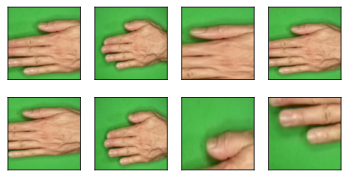

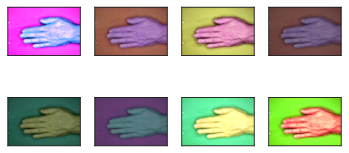

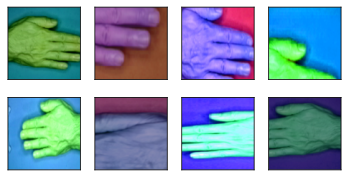

In [51]:
import torchvision
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)
    
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)
    
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

In [42]:
# import torch
import torchvision
from d2l import torch as d2l
img = np.array(Image.open('data/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png'))

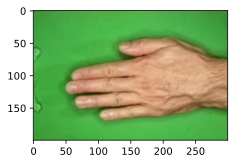

In [43]:
d2l.set_figsize()
img = d2l.Image.open('data/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png')
d2l.plt.imshow(img);

In [44]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

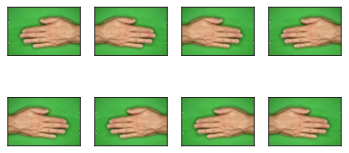

In [45]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

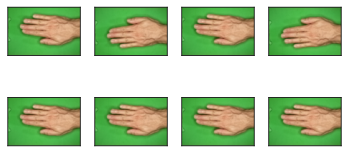

In [46]:
apply(img, torchvision.transforms.RandomVerticalFlip())

In [81]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])


from PIL import Image



def fuck_images(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.jpeg', '.png')):

            image_path = os.path.join(input_folder, filename)
            img = d2l.Image.open(image_path)
#             img = Image.open(image_path)
#             img = cv2.imread(image_path)
            
            fucked_img = augs(img)
        
            output_filename = f"{filename}"
            output_path = os.path.join(output_folder, output_filename)
            fucked_img.save(output_path)
#             cv2.imwrite(output_path, fucked_img)



# input_folder = "data/rockpaperscissors/rock"
# output_folder = "data/rockpaperscissors/rock-fucked"
# clear_folder(output_folder)
# fuck_images(input_folder, output_folder)

# input_folder = "data/rockpaperscissors/paper"
# output_folder = "data/rockpaperscissors/paper-fucked"
# clear_folder(output_folder)
# fuck_images(input_folder, output_folder)

input_folder = "data/rockpaperscissors/scissors"
output_folder = "data/rockpaperscissors/scissors-fucked"
clear_folder(output_folder)
fuck_images(input_folder, output_folder)

In [82]:
TRAIN_N, TEST_N = 500, 200
N = TRAIN_N + TEST_N

classes = ['rock-fucked', 'paper-fucked', 'scissors-fucked']

TRAIN_N, TEST_N = len(classes)*TRAIN_N, len(classes)*TEST_N

X = []
y = []

color_transform = np.array([65536, 256, 1])

for class_id, class_name in enumerate(classes):
    for filename in os.listdir(f'./data/rockpaperscissors/{class_name}')[:N]:
        image = np.array(Image.open(f'./data/rockpaperscissors/{class_name}/{filename}'))
        X.append(image.dot(color_transform).flatten())
        y.append(class_id)

perm = np.random.permutation(len(y))

X = np.array(X)[perm]
y = np.array(y)[perm]

train_X, train_y = X[:TRAIN_N], y[:TRAIN_N]
test_X, test_y = X[TRAIN_N:], y[TRAIN_N:]

In [83]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X, train_y)
model.score(test_X, test_y)

0.45666666666666667

In [84]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(train_X)

X_trn_pca = pca.transform(train_X)
# X_trn_pca.shape
X_tst_pca = pca.transform(test_X)
# X_tst_pca.shape

clf_pca = KNeighborsClassifier(n_neighbors=10, n_jobs=-1)
clf_pca.fit(X_trn_pca, train_y)

# (clf_pca.predict(X_trn_pca) == train_Y).mean()
print((clf_pca.predict(X_tst_pca) == test_y).mean())

0.4683333333333333


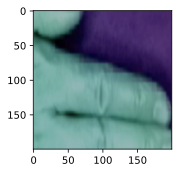

In [75]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
plt.imshow(augs(img))
plt.show()

# d2l.show_images(augs(img), 1, 1, scale=1)

# from PIL import Image
# image_path = 'data/rockpaperscissors/paper/04l5I8TqdzF9WDMJ.png'
# img = Image.open(image_path)
# output_path = 'data/rockpaperscissors/rock-fucked/04l5I8TqdzF9WDMJ.png'
# img.save(output_path)